In [1]:
# Importing necessary models
import warnings
warnings.filterwarnings('ignore')

import smtplib
import pandas as pd
import numpy as np
import datetime as dt
import pandas.stats.moments as st
import time
%matplotlib inline
from bs4 import BeautifulSoup as bs
import requests
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sqlalchemy import *
from sqlalchemy import create_engine
import calendar
import sqlite3 as sql
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:,.4f}'.format

init_notebook_mode(connected=True)

import os
main_dir = os.getcwd()

dbs_dir = 'C:\\Users\\Fang\\Desktop\\Python Trading\\Trading\\Data\\DBs'

os.chdir('C:\\Users\\Fang\\Desktop\\Python Trading\\Trading\\Trading\\Modules\\DataCollection')

from yahoo_query import *

os.chdir('D:\Price Data\SPX and VIX Intraday TWS')

ib_index_engine = create_engine('sqlite:///ib_index_intraday.db', echo = False)

In [52]:
start_date = dt.datetime(1970,1,2)

spx = yahoo_query('^GSPC', start_date)
spx.hist_prices_query()
spx = spx.hist_prices
# vix = yahoo_query('^VIX', start_date)
# vix.hist_prices_query()
# vix = vix.hist_prices

# index_df = spx.join(vix)[['^GSPC_open','^GSPC_adjclose','^VIX_open','^VIX_adjclose']]
# index_df.columns = ['SPX_open','SPX_close','VIX_open','VIX_close']
# index_df['implied_vix_open_1day'] = index_df.VIX_open/(np.sqrt(365)*100)
# index_df['implied_vix_close_1day'] = index_df.VIX_close/(np.sqrt(365)*100)
# index_df['SPX_move_vix_open'] = (index_df.SPX_close/index_df.SPX_open - 1)/index_df.implied_vix_open_1day
# index_df['SPX_move_vix_close'] = (index_df.SPX_close/index_df.SPX_close.shift(1) - 1)/index_df.implied_vix_close_1day.shift(1)
# stand_moves = index_df[['VIX_open','SPX_move_vix_open','SPX_move_vix_close']].dropna()

In [12]:
for vix_lb in range(9, 85, 5):
    if vix_lb < 79:
        print('VIX Between: {0} - {1}'.format(vix_lb, vix_lb + 5))
        stand_moves[(stand_moves.VIX_open < vix_lb + 5) &
                    (stand_moves.VIX_open >= vix_lb)][['SPX_move_vix_open','SPX_move_vix_close']].hist(figsize = (20,5), bins = 30)
        plt.show()

In [248]:
query = "SELECT date, open_spx, high_spx, low_spx, close_spx, open_vix, high_vix, low_vix, close_vix FROM indexIntraday"

minutes_mod = 30

index_intraday = pd.read_sql_query(query, con = ib_index_engine, index_col = 'date')
index_intraday.index = pd.to_datetime(index_intraday.index)
index_intraday = index_intraday.sort_index()
index_intraday['date_day'] = index_intraday.index.date
index_intraday['EOD'] = (index_intraday['date_day'].shift(-1) - index_intraday['date_day']).dt.days
index_intraday['BOD'] = (index_intraday['date_day'].shift(1) - index_intraday['date_day']).dt.days
index_intraday = index_intraday.fillna(1)
index_intraday['TimeFilter'] = index_intraday.index.minute%minutes_mod



In [249]:
intraday_df = index_intraday[(index_intraday['EOD'] != 0) |
                             (index_intraday['BOD']) != 0 |
                             (index_intraday['TimeFilter'] == 0)]

intraday_df['implied_std_move'] = intraday_df.close_vix/(np.sqrt(365*(390/minutes_mod))*100)
intraday_df['spx_std_move'] = (intraday_df.close_spx.shift(-1)/intraday_df.close_spx - 1)/intraday_df.implied_std_move
intraday_df['spx_std_move'] = intraday_df['spx_std_move'].shift(1)
intraday_df['implied_upper'] = intraday_df.close_spx*(1 + intraday_df.implied_std_move)
intraday_df['implied_lower'] = intraday_df.close_spx*(1 - intraday_df.implied_std_move)
intraday_df['implied_upper'] = intraday_df['implied_upper'].shift(1)
intraday_df['implied_lower'] = intraday_df['implied_lower'].shift(1)

intraday_df['implied_upper'] = round(intraday_df.implied_upper*0.2,0)*5
intraday_df['implied_lower'] = round(intraday_df.implied_lower*0.2,0)*5

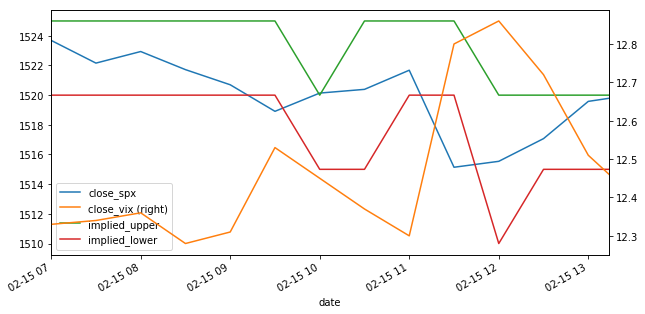

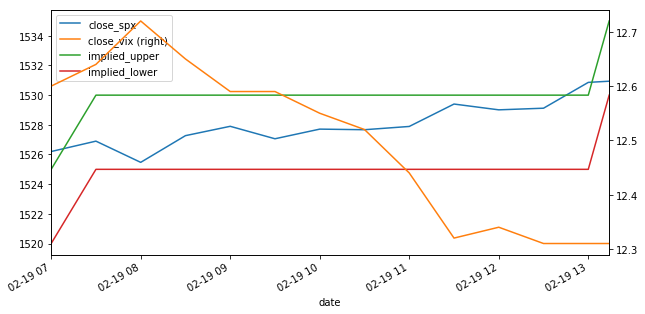

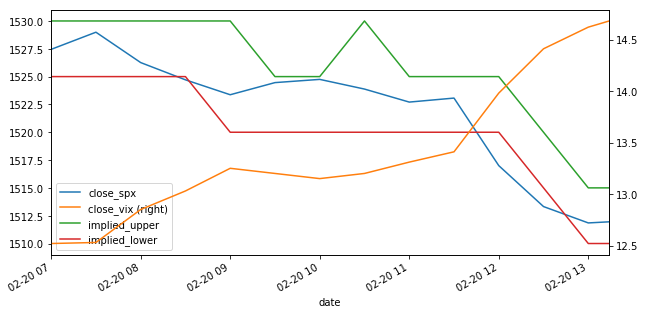

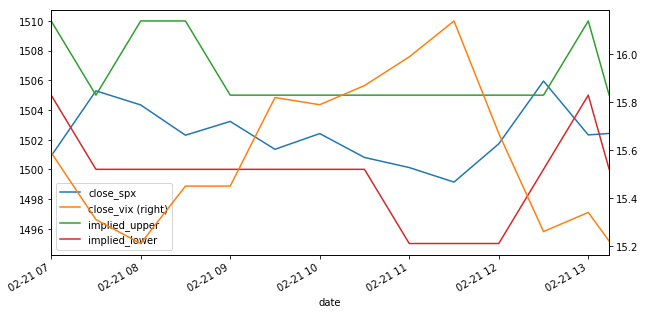

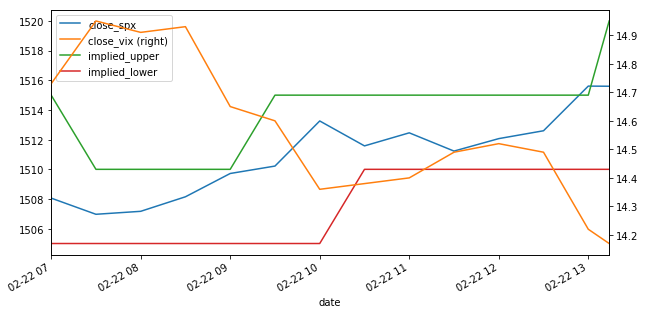

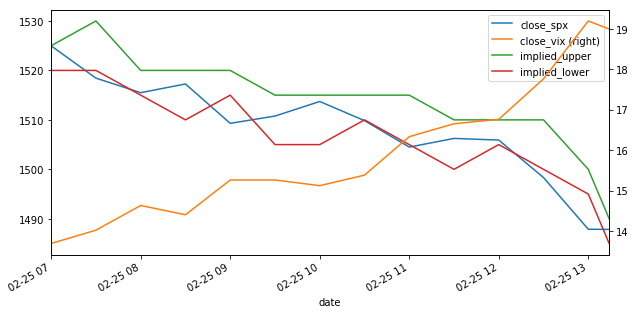

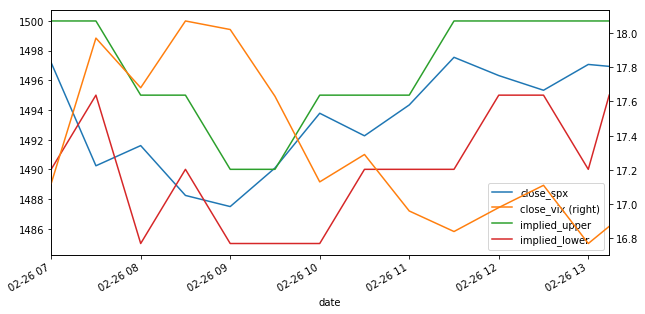

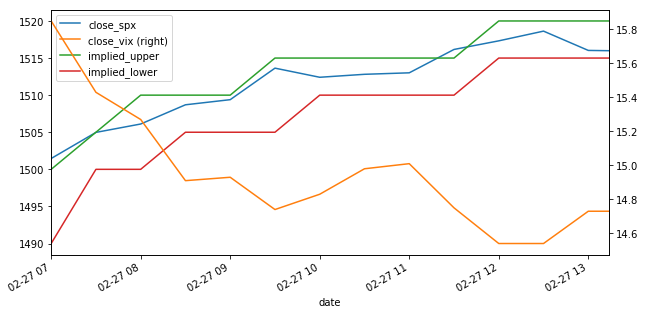

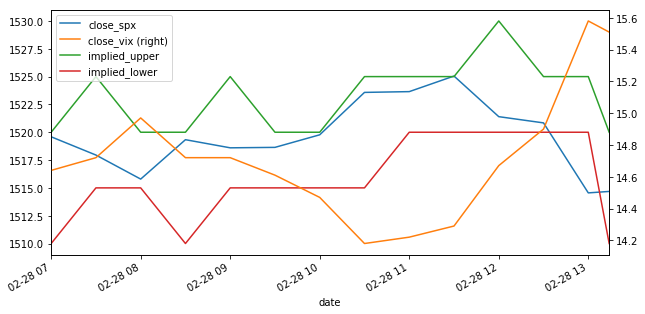

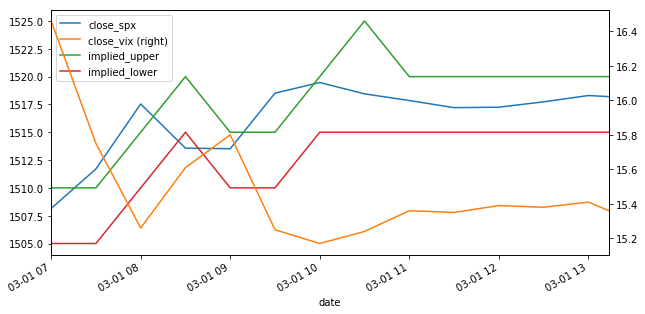

In [297]:
break_count = 0
breaker_point = 10

show_graphs = True

intraday_summary = {'Date': [],
                    'Open_VIX': []}

for curr_date in intraday_df['date_day'].drop_duplicates().tolist()[10:]:
    curr_df = intraday_df[(intraday_df['date_day'] == curr_date)]
    
    intraday_summary['Date'].append(curr_date)
    intraday_summary['Open_VIX'].append(curr_df.reset_index().loc[0,'close_vix'])
    curr_df = curr_df[(curr_df['BOD'] == 0)]
    
    curr_df['Breached'] = (curr_df.close_spx > curr_df.implied_upper) + (curr_df.close_spx < curr_df.implied_lower)
    
    
    step_size = round(len(curr_df[['close_vix','Breached']])/4) + 1
    
    time_block_num = 1
    for step in range(0, len(curr_df), step_size):
        
        
        
        if time_block_num < 3:
            curr_block_label = 'TimeBlock_{}_Breaches'.format(time_block_num)
            
            if intraday_summary.get(curr_block_label, 0) == 0:
                intraday_summary[curr_block_label] = []
            
            curr_block = curr_df.iloc[step:step + step_size, :]
            intraday_summary[curr_block_label].append(curr_block.Breached.sum())
            time_block_num += 1
            
        else:
            curr_block = curr_df.iloc[step:, :]            
            curr_block_label = 'TimeBlock_{}_Breaches'.format(time_block_num)
            
            if intraday_summary.get(curr_block_label, 0) == 0:
                intraday_summary[curr_block_label] = []
            intraday_summary[curr_block_label].append(curr_block.Breached.sum())
            break
            
    if show_graphs:
        curr_df[['close_spx','close_vix','implied_upper','implied_lower']].plot(figsize = (10,5),
                                                                                secondary_y = 'close_vix')
        plt.show()

        break_count += 1

        if break_count == breaker_point:
            break
intraday_summary = pd.DataFrame(intraday_summary).set_index('Date')

(8.9800000000000004, 15.850000000000001)


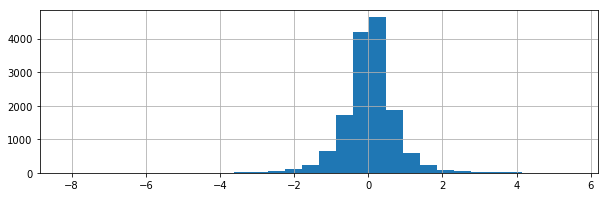

(15.850000000000001, 22.720000000000002)


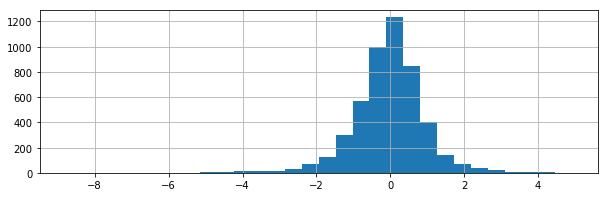

(22.720000000000002, 29.590000000000003)


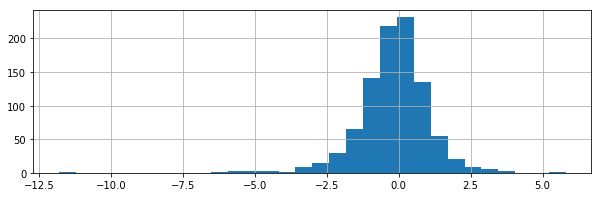

(29.590000000000003, 36.460000000000008)


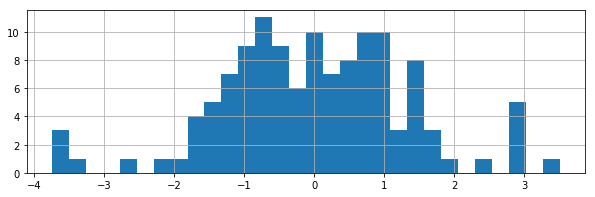

(36.460000000000008, 43.330000000000013)


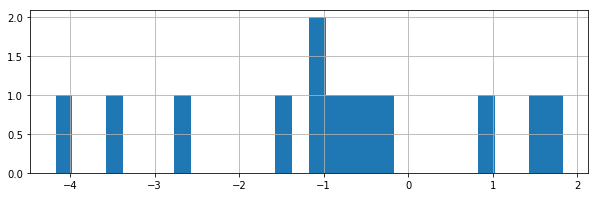

(43.330000000000013, 50.200000000000003)


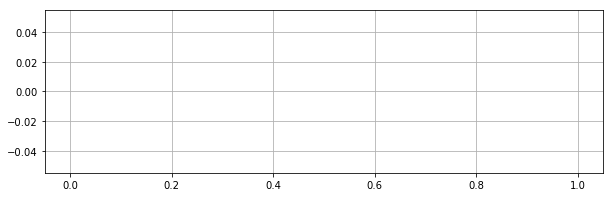

In [291]:
vix_bins = np.arange(intraday_df['close_vix'].min(), 
                     intraday_df['close_vix'].max() + 6,
                     (intraday_df['close_vix'].max() - intraday_df['close_vix'].min())/6)
vix_bins = list(zip(vix_bins[:-1],vix_bins[1:]))


for bins in vix_bins:
    print(bins)
    curr_summary = intraday_df[(intraday_df.close_vix >= bins[0]) &
                               (intraday_df.close_vix < bins[1])]
    
    curr_summary.spx_std_move.hist(figsize = (10,3), bins = 30)
    plt.show()
#     print(len(curr_summary))
#     print(curr_summary.iloc[:, 1:].sum()/(len(curr_summary)*len(curr_df)))

In [293]:
index_intraday

open_spx   high_spx    low_spx  close_spx  open_vix  \
date                                                                        
2013-02-01 06:31:00 1,504.6900 1,505.9300 1,504.6300 1,505.9300   13.3700   
2013-02-01 06:32:00 1,506.1900 1,506.9600 1,506.0900 1,506.9500   13.3600   
2013-02-01 06:33:00 1,507.0900 1,507.3700 1,507.0900 1,507.2300   13.3500   
2013-02-01 06:34:00 1,507.1200 1,507.1200 1,505.7700 1,505.7700   13.3500   
2013-02-01 06:35:00 1,505.8100 1,506.0000 1,505.5300 1,505.9700   13.3600   
2013-02-01 06:36:00 1,505.9200 1,506.1400 1,505.6100 1,505.6100   13.3500   
2013-02-01 06:37:00 1,505.6800 1,505.8400 1,505.2200 1,505.2400   13.3700   
2013-02-01 06:38:00 1,505.2100 1,505.3500 1,505.1900 1,505.3400   13.3800   
2013-02-01 06:39:00 1,505.3300 1,505.8200 1,505.3300 1,505.5200   13.3700   
2013-02-01 06:40:00 1,505.6400 1,506.1100 1,505.6400 1,506.1100   13.3600   
2013-02-01 06:41:00 1,506.1000 1,506.2400 1,506.0200 1,506.2400   13.3600   
2013-02-01 06:42:00 1,506.2300 1,506.6700 1,506.2300 1,506.3300   13.3500   
2013-02-01 06:43:00 1,506.4000 1,506.5400 1,506.2400 1,506.3900   13.3500   
2013-02-01 06:44:00 1,506.3700 1,506.6400 1,506.3400 1,506.4900   13.3500   
2013-02-01 06:45:00 1,506.4000 1,506.7100 1,506.2500 1,506.2500   13.3400   
2013-02-01 06:46:00 1,505.8100 1,506.2200 1,505.7800 1,506.2200   13.3400   
2013-02-01 06:47:00 1,506.2100 1,506.2900 1,505.8500 1,505.8500   13.3400   
2013-02-01 06:48:00 1,505.6300 1,505.7900 1,505.4600 1,505.5200   13.3500   
2013-02-01 06:49:00 1,505.5800 1,505.5800 1,505.2500 1,505.2500   13.3400   
2013-02-01 06:50:00 1,505.1100 1,505.1900 1,504.9700 1,504.9700   13.3500   
2013-02-01 06:51:00 1,504.6900 1,504.9300 1,504.5800 1,504.8600   13.3500   
2013-02-01 06:52:00 1,504.8900 1,505.4300 1,504.8800 1,505.4300   13.3200   
2013-02-01 06:53:00 1,505.4500 1,505.7700 1,505.4400 1,505.4500   13.3100   
2013-02-01 06:54:00 1,505.3800 1,505.5100 1,505.3800 1,505.4900   13.3200   
2013-02-01 06:55:00 1,505.9900 1,506.6700 1,505.9900 1,506.3400   13.3300   
2013-02-01 06:56:00 1,506.1500 1,506.1500 1,505.8200 1,506.0200   13.2300   
2013-02-01 06:57:00 1,506.0000 1,506.0000 1,505.7500 1,505.7500   13.2300   
2013-02-01 06:58:00 1,505.7600 1,505.8400 1,505.0500 1,505.0500   13.2400   
2013-02-01 06:59:00 1,505.0100 1,505.1100 1,504.6400 1,504.6400   13.2500   
2013-02-01 07:00:00 1,504.8700 1,507.6600 1,504.8700 1,507.2100   13.3400   
...                        ...        ...        ...        ...       ...   
2019-03-01 12:30:00 2,801.3400 2,801.9700 2,801.0400 2,801.3500   13.5100   
2019-03-01 12:31:00 2,801.3400 2,801.3500 2,800.8300 2,800.9300   13.5300   
2019-03-01 12:32:00 2,800.9100 2,801.2500 2,800.8700 2,801.1300   13.5400   
2019-03-01 12:33:00 2,801.1500 2,801.5200 2,800.9400 2,800.9400   13.5000   
2019-03-01 12:34:00 2,800.9300 2,800.9300 2,800.5300 2,800.7900   13.5300   
2019-03-01 12:35:00 2,800.8000 2,801.1000 2,800.6500 2,801.0800   13.5300   
2019-03-01 12:36:00 2,801.0500 2,802.1100 2,801.0400 2,802.1100   13.5200   
2019-03-01 12:37:00 2,802.1400 2,803.3000 2,802.1400 2,803.0300   13.4600   
2019-03-01 12:38:00 2,803.0600 2,803.2400 2,802.9200 2,802.9200   13.4800   
2019-03-01 12:39:00 2,802.9100 2,803.0500 2,802.6700 2,803.0300   13.5100   
2019-03-01 12:40:00 2,803.0100 2,803.5100 2,802.9000 2,803.5000   13.5000   
2019-03-01 12:41:00 2,803.5200 2,803.9000 2,803.5000 2,803.8700   13.4800   
2019-03-01 12:42:00 2,803.8400 2,804.1600 2,803.7300 2,804.1600   13.4800   
2019-03-01 12:43:00 2,804.1800 2,804.3800 2,804.1600 2,804.2100   13.4900   
2019-03-01 12:44:00 2,804.2400 2,806.0700 2,804.2300 2,806.0700   13.4800   
2019-03-01 12:45:00 2,806.1800 2,806.5600 2,806.1100 2,806.2900   13.4100   
2019-03-01 12:46:00 2,806.3100 2,806.3100 2,806.0500 2,806.0800   13.4500   
2019-03-01 12:47:00 2,805.9900 2,805.9900 2,804.2800 2,804.4500   13.4600   
2019-03-01 12:48:00 2,804.4100 2,804.4100 2,803.8800 2,804.3100   13.5400   
2019-03-01 12:49:0

In [300]:
print("Upper Bound: {}".format((1 + (13.51/(np.sqrt(365*(390/30))*100)))*2803.69))
print("Lower Bound: {}".format((1 - (13.51/(np.sqrt(365*(390/30))*100)))*2803.69))

Upper Bound: 2809.188791254394
Lower Bound: 2798.1912087456067


In [66]:
spx_df = spx[['^GSPC_adjclose']]
spx_df.columns = ['spx']
spx_df['year'] = spx_df.index.year
spx_df['month'] = spx_df.index.month
# spx_df['boy'] = (spx_df.year - spx_df.year.shift(1)).fillna(1)
# spx_df['eoy'] = (spx_df.year.shift(-1) - spx_df.year)

conditional_returns = {'year':[],
                       'YTD_return_April':[],
                       'YTD_return_Post_April':[]}

for year in spx_df.year.drop_duplicates():
    curr_spx = spx_df[spx_df.year == year]
    boy_spx = curr_spx.iloc[0,0]
    eoy_spx = curr_spx.iloc[len(curr_spx) - 1, 0]
    q1_spx = curr_spx[curr_spx.month == 3].tail(1)['spx'].values[0]
    conditional_returns['year'].append(year)
    conditional_returns['YTD_return_April'].append(q1_spx/boy_spx-1)
    conditional_returns['YTD_return_Post_April'].append(eoy_spx/q1_spx-1)
    
conditional_returns = pd.DataFrame(conditional_returns).set_index('year')

In [68]:
conditional_returns[conditional_returns.YTD_return_April > 0.1]

YTD_return_April  YTD_return_Post_April
year                                         
1971            0.1005                 0.0177
1975            0.1870                 0.0819
1976            0.1306                 0.0456
1983            0.1057                 0.0783
1986            0.1398                 0.0137
1987            0.1836                -0.1530
1991            0.1494                 0.1116
1998            0.1300                 0.1157
2012            0.1029                 0.0126
2019            0.1292                 0.0136